In [1]:
import pickle
import random

from colormath.color_objects import AdobeRGBColor, sRGBColor, LabColor
from colormath.color_conversions import convert_color
import numpy as np
import matplotlib.pyplot as plt

from image_colorization import *
from utils import *

%matplotlib inline

In [2]:
image_list = get_images()

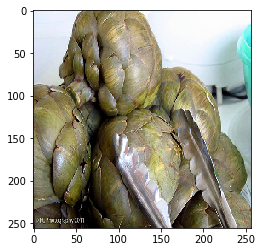

In [3]:
image = Image.open(random.choice(image_list))
image = image.resize((256, 256))

image_rgb = np.array(image)
image_lab = color.rgb2lab(image_rgb)
image_lab = image_lab.transpose(2, 0, 1)

plt.imshow(color.lab2rgb(image_lab.transpose(1, 2, 0).astype(np.float64)))

In [4]:
quantize_step = 10

In [5]:
def quantize():
    groups = {}
    L = 50
    counter = 0
    for a in range(-128, 128, quantize_step):
        for b in range(-128, 128, quantize_step):
            lab = LabColor(L, a, b)
            rgb = convert_color(lab, sRGBColor)
            if rgb.rgb_r >= 0 and rgb.rgb_r <= 1 and rgb.rgb_b >= 0 and rgb.rgb_b <= 1 and rgb.rgb_g >= 0 and rgb.rgb_g <= 1:
                groups[(a, b)] = counter
                counter += 1
    return groups

In [6]:
ab2cat = quantize()
cat2ab = {v: k for k, v  in ab2cat.items()}

n_spaces = len(ab2cat)

In [17]:
with open('cache/ab2cat_10.pkl', 'wb') as f:
    pickle.dump(ab2cat, f)

with open('cache/cat2ab_10.pkl', 'wb') as f:
    pickle.dump(cat2ab, f)

In [7]:
with open('cache/nearest_neighbors.pkl', 'rb') as f:
    nearest_neighbors = pickle.load(f)

In [8]:
for a in range(-130, 130):
    for b in range(-130, 130):
        if (a, b) in nearest_neighbors:
            continue
        ab = np.array([a, b])
        nearest_5 = sorted(ab2cat.items(), key=lambda item: np.linalg.norm(ab - np.array(item[0])))[:5]
        nearest_5 = [tup[1] for tup in nearest_5]
        nearest_neighbors[(a, b)] = nearest_5        

In [10]:
preprocessor = lambda label: get_smoothed_label(label, nearest_neighbors, ab2cat)
dset = ColorizationDataset(image_list, preprocessor)

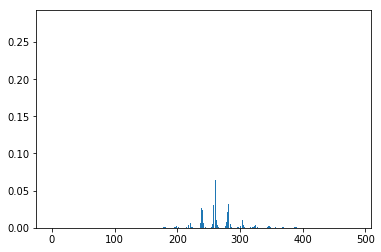

In [11]:
distribution = np.zeros(len(ab2cat))
for i in range(len(dset)):
    img, label = dset[i]
    count = np.bincount(np.argmax(label.numpy(), axis=0).reshape(-1))
    for val, freq in enumerate(count):
        distribution[val] += freq

distribution /= np.sum(distribution)

plt.bar(np.arange(n_spaces), distribution)
plt.show()

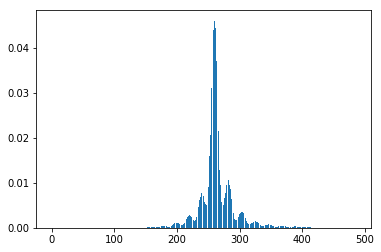

In [12]:
smoothed_dist = gaussian_smooth(distribution)
plt.bar(np.arange(n_spaces), smoothed_dist)
plt.show()

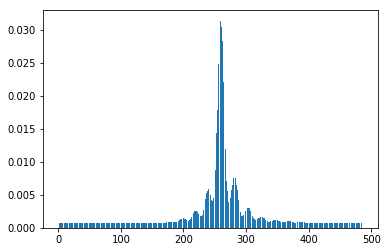

In [13]:
L = 0.5
smoothed_dist += L / n_spaces
smoothed_dist /= np.sum(smoothed_dist)
plt.bar(np.arange(n_spaces), smoothed_dist)
plt.show()

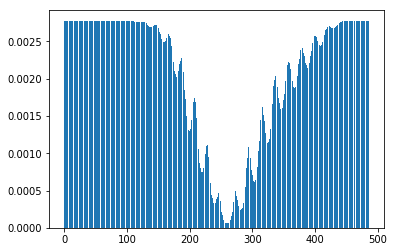

In [14]:
inv_dist = 1 / smoothed_dist
inv_dist /= np.sum(inv_dist)
plt.bar(np.arange(n_spaces), inv_dist)
plt.show()

In [15]:
np.savetxt('cache/class_weights.txt', inv_dist)